# Compare Microlens Modeling Packages

This notebook compares the microlens models produced by the following modeling packages:

* BAGLE v1.0
* pyLIMA v1.9.8
* VBMicrolensing v5.3.3
* MuLensModel v3.3.1

We will compare photometry-only, photometry+astrometry models, with/without parallax models, single/binary models, and point-source/finite-source models. This notebook was developed using the version numbers listed above.  

In [31]:
import bagle
import pyLIMA
import VBMicrolensing
import MulensModel

import numpy as np
import pylab as plt
from bagle import plot_models
from pyLIMA.astrometry import astrometric_positions as pyLIMA_ast
from astropy.coordinates import SkyCoord
from astropy import units

print('** Versions **')
print('BAGLE     = ', bagle.__version__)
print('pyLIMA    = ', pyLIMA.__version__)
print('MulensMod = ', MulensModel.__version__)
#print('VBM       = ', VBMicrolensing.__version__)  # use pip show VBMicrolensing instead

!pip show VBMicrolensing

from bagle import model
from bagle import frame_convert as fc

%matplotlib inline

** Versions **
BAGLE     =  1.0.dev0
pyLIMA    =  1.9.8
MulensMod =  3.3.1
Name: VBMicrolensing
Version: 5.3.3
Summary: VBMicrolensing is a tool for efficient computation in gravitational microlensing events using the advanced contour integration method, supporting single, binary and multiple lenses.
Home-page: 
Author: 
Author-email: Valerio Bozza <valboz@sa.infn.it>, Vito Saggese <vitosaggese.vs@gmail.com>
License: LGPL-3.0
Location: /Users/jlu/.local/lib/python3.11/site-packages
Requires: numpy, pytest
Required-by: pyLIMA


## Photometry-Only, Single, Point-Source Models

Setup BAGLE parameters, which are all in Solar System Barycentric coordinates. Note, these models have parallax.

In [14]:
# Setup the BAGLE parameters
c = SkyCoord('17:57:05 -30:22:59', unit=(units.hourangle, units.deg))
ra_bagle = float(c.ra.value)
dec_bagle = float(c.dec.value)
t0_bagle = 55775.0  # MJD units in TDB reference (SS barycentric)
u0_amp_bagle = 1.0  # thetaE
tE_bagle = 100      # days
piEE_bagle = 0.9 
piEN_bagle = 0.7 
mag_src_bagle = 19
b_sff_bagle = 1
t0_par_bagle = t0_bagle  # The reference time is set to default t0_par = t0

Define time arrays for plotting the models.

In [15]:
# Time arrays
time_mjd = np.arange(t0_bagle - 6 * tE_bagle, t0_bagle + 6 * tE_bagle)
time_jd = time_mjd + 2400000.5

### Setup the BAGLE model

Get the BAGLE model instance and the resulting amplification.

In [16]:
bagle_mod = model.PSPL_Phot_Par_Param1(t0_bagle, u0_amp_bagle, tE_bagle, piEE_bagle, piEN_bagle,
                                         [b_sff_bagle], [mag_src_bagle], raL=ra_bagle, decL=dec_bagle)

amp_bagle = bagle_mod.get_amplification(time_mjd)

### Setup the PyLIMA model

In [17]:
pylima_mod, pylima_par, pylima_tel = fc.get_pylima_model(bagle_mod, times_mjd = time_mjd)
amp_pylima = pylima_mod.model_magnification(pylima_tel, pylima_par)

### Setup the MulensModel model

In [18]:
mulens_mod = fc.get_mulens_model(bagle_mod)
amp_mulens = mulens_mod.get_magnification(time_jd)

### Setup the VBM model

In [19]:
vbm_mod, vbm_par = fc.get_vbm_model(bagle_mod)
time_mjd_prime_50000 = fc.mjd_prime_to_vbm_time(time_mjd, c)
tmp_vbm = vbm_mod.PSPLLightCurveParallax(vbm_par, time_mjd_prime_50000)
amp_vbmicr = tmp_vbm[0]

### Plots

compare_model_pkg_amp: BAGLE parameters
$t_{E,\odot}=100$ days, $u_{0,\odot}=1.0$, $t_{0,\odot}=55775$ MJD, $b_{sff}[0]=1$, $mag_S[0]=19$ mag


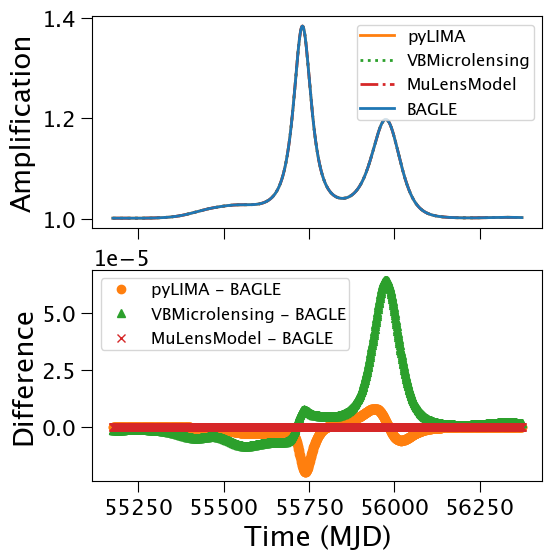

In [20]:
plot_models.compare_model_pkg_phot_amp(bagle_mod, time_mjd, amp_pylima, amp_vbmicr, amp_mulens)

## Photometry+Astrometry, Single Point-Source Models

### Setup the BAGLE model

Model parameters now include astrometric parameters such as $\theta_E$ and $\mu_S$.

In [21]:
c = SkyCoord('17:57:05 -30:22:59', unit=(units.hourangle, units.deg))
ra_bagle = float(c.ra.to(units.deg).value)
dec_bagle = float(c.dec.to(units.deg).value)
t0_bagle = 55775.0
u0_amp_bagle = 0.5  # thetaE
tE_bagle = 100.0  # days
thetaE_bagle = 3.0  # mas
piEE_bagle = 0.2
piEN_bagle = 0.1
piS_bagle = 0.1  # mas
muSE_bagle = 1  # mas/yr
muSN_bagle = 2  # mas/yr
xS0E_bagle = -thetaE_bagle * u0_amp_bagle * 1e-3  # arcsec
xS0N_bagle = thetaE_bagle * u0_amp_bagle * 1e-3  # arcsec
mag_src_bagle = 19
b_sff_bagle = 1.0
t0_par_bagle = t0_bagle  # The reference time is set to default t0_par = t0

muRelHat = np.array([piEE_bagle, piEN_bagle]) / np.hypot(piEE_bagle, piEN_bagle)

Time arrays go out a little longer now for good astrometric coverage. 

In [22]:
time_mjd = np.arange(t0_bagle - 6 * tE_bagle, t0_bagle + 6 * tE_bagle)
time_jd = time_mjd + 2400000.5

BAGLE model instance.

In [23]:
pspl_bagle = model.PSPL_PhotAstrom_Par_Param2(t0_bagle, u0_amp_bagle, tE_bagle,
                                                  thetaE_bagle, piS_bagle, piEE_bagle, piEN_bagle,
                                                  xS0E_bagle, xS0N_bagle, muSE_bagle, muSN_bagle,
                                                  [b_sff_bagle], [mag_src_bagle],
                                                  raL=ra_bagle, decL=dec_bagle)
amp_bagle = pspl_bagle.get_amplification(time_mjd)
uvec_bagle = pspl_bagle.get_u(time_mjd)
xS_bagle = pspl_bagle.get_source_astrometry_unlensed(time_mjd)  # arcsec
xL_bagle = pspl_bagle.get_lens_astrometry(time_mjd)
ast_lensed_bagle = pspl_bagle.get_astrometry(time_mjd)

### Setup the PyLIMA model

In [24]:
#####
# PyLIMA Model
#####
pylima_mod, pylima_par, pylima_tel = fc.get_pylima_model(pspl_bagle, times_mjd = time_mjd)

# Amplification
amp_pylima = pylima_mod.model_magnification(pylima_tel, pylima_par)

# Positions in arcseconds
xS_pylima = np.array(pyLIMA_ast.source_astrometric_positions(pylima_tel, pylima_par)).T * 3600.0
xL_pylima = np.array(pyLIMA_ast.lens_astrometric_positions(pylima_mod, pylima_tel, pylima_par)).T * 3600.0
ast_lensed_pylima = np.array(pylima_mod.model_astrometry(pylima_tel, pylima_par)).T * 3600.0
uvec_pylima = (xS_pylima - xL_pylima) / (pylima_par['theta_E'] * 1e-3)   # spot [3] is thetaE

### Setup the VBM model 

In [25]:
#####
# VBMicrolensing Model
#####
vbm_mod, vbm_par = fc.get_vbm_model(pspl_bagle)
u0_vbm = vbm_par[0]
piEE_vbm = vbm_par[4]
piEN_vbm = vbm_par[3]

time_vbm = fc.mjd_prime_to_vbm_time(time_mjd, c)

tmp_vbmicr = vbm_mod.PSPLAstroLightCurve(vbm_par, time_vbm)
amp_vbmicr = tmp_vbmicr[0]
ast_lensed_vbmicr = np.array([tmp_vbmicr[2], tmp_vbmicr[1]]).T * 1e-3
xL_vbmicr = np.array([tmp_vbmicr[4], tmp_vbmicr[3]]).T * 1e-3
u_vbmicr_tb = np.array([tmp_vbmicr[6], tmp_vbmicr[5]]).T  # [beta, tau]

# Rotate u vector from t-b frame to E-N frame.
muRel_hat_vbm = np.array([piEE_vbm, piEN_vbm]) / np.hypot(piEE_vbm, piEN_vbm)
u0_hat_vbm = model.u0_hat_from_thetaE_hat(muRel_hat_vbm, u0_vbm)
u0_hat_vbm[1] *= -1
uvec_vbmicr = u_vbmicr_tb[:, 1, np.newaxis] * muRel_hat_vbm[np.newaxis, :] + \
u_vbmicr_tb[:, 0, np.newaxis] * u0_hat_vbm[np.newaxis, :]

# Repair lens position vector to account for non-zero xL0
xL_vbmicr += pspl_bagle.xL0
# Correct lensed astrometry to account for non-zero xL0
ast_lensed_vbmicr += pspl_bagle.xL0

# Calculate xS vector (source position)
xS_vbmicr = uvec_vbmicr * pspl_bagle.thetaE_amp * 1e-3 + xL_vbmicr  # arcsec

### Plots

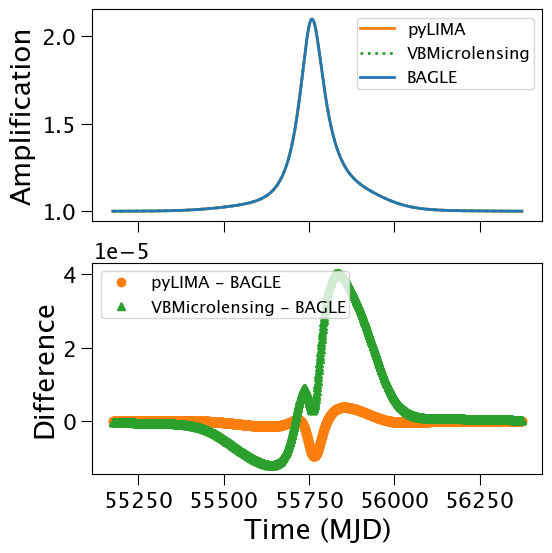

In [26]:
plot_models.compare_model_pkg_phot_astrom_amp(time_mjd, amp_bagle, amp_pylima, amp_vbmicr)

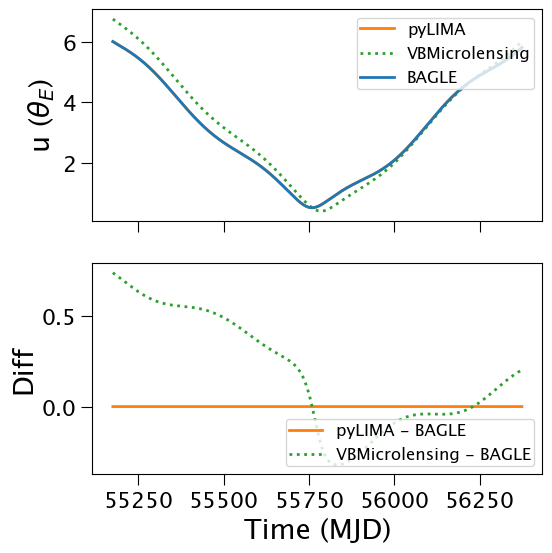

In [27]:
uamp_pylima = np.hypot(uvec_pylima[:, 0], uvec_pylima[:, 1])
uamp_vbmicr = np.hypot(uvec_vbmicr[:, 0], uvec_vbmicr[:, 1])
uamp_bagle = np.hypot(uvec_bagle[:, 0], uvec_bagle[:, 1])

plot_models.compare_model_pkg_phot_astrom_uamp(time_mjd, uamp_bagle, uamp_pylima, uamp_vbmicr)

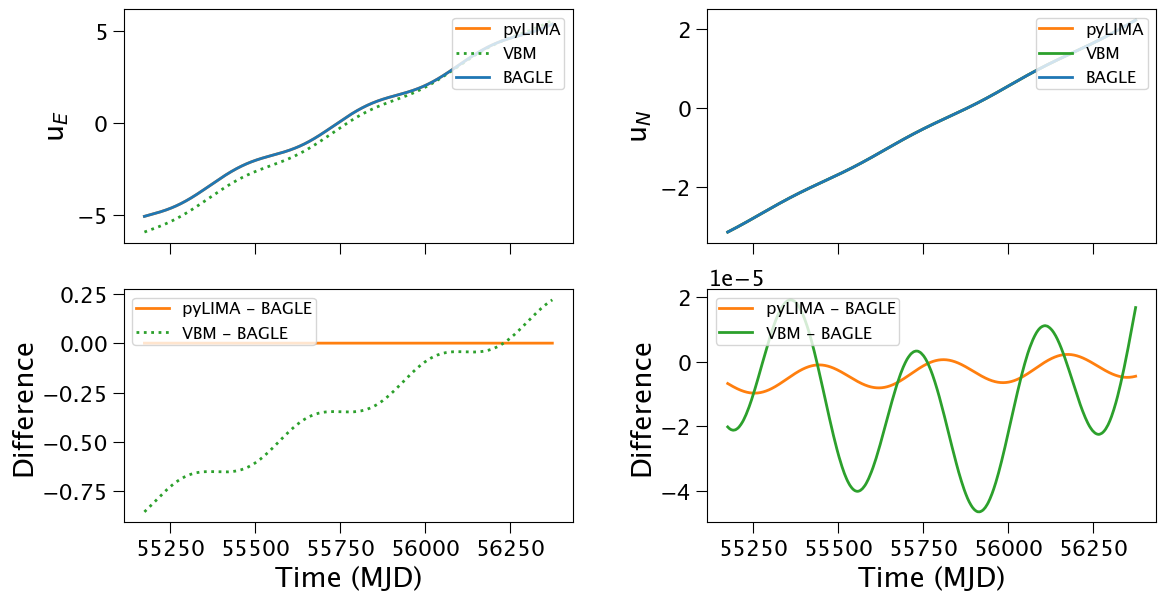

In [28]:
plot_models.compare_model_pkg_phot_astrom_uvec(time_mjd, uvec_bagle, uvec_pylima, uvec_vbmicr)

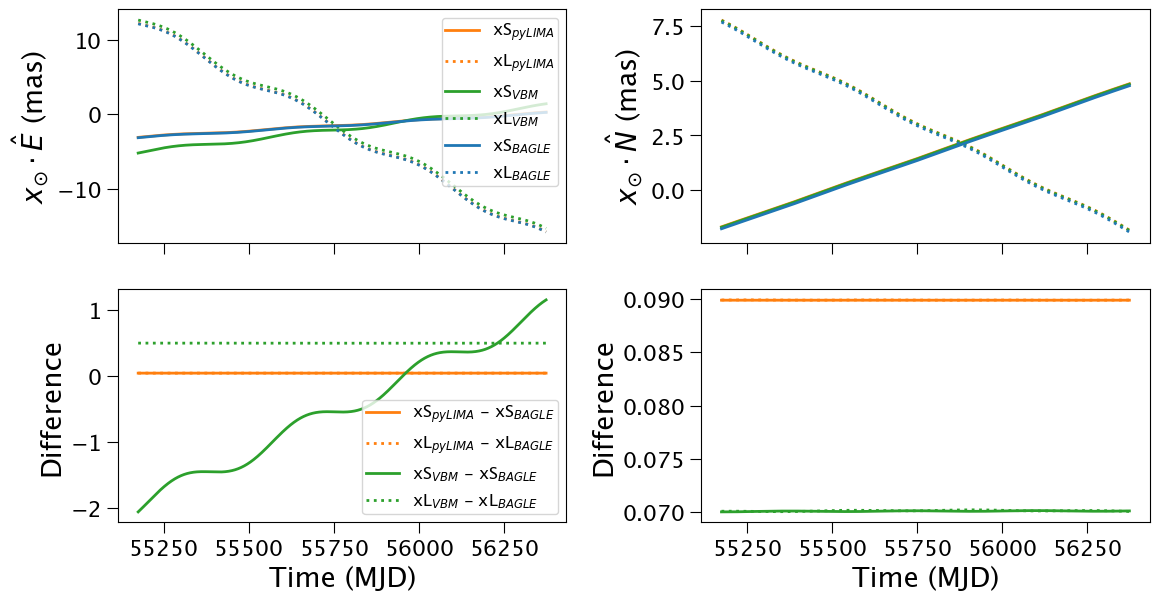

In [29]:
plot_models.compare_model_pkg_phot_astrom_xSxL(time_mjd, 
                                               xS_bagle, xL_bagle, 
                                               xS_pylima, xL_pylima, 
                                               xS_vbmicr, xL_vbmicr)

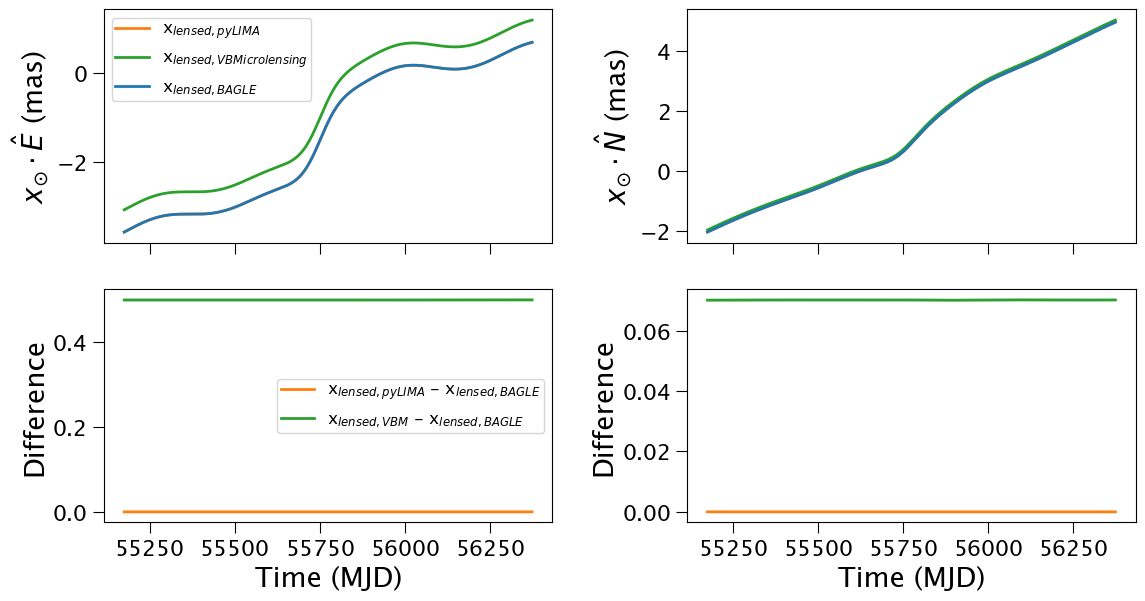

In [30]:
plot_models.compare_model_pkg_phot_astrom_cent(time_mjd, 
                                               ast_lensed_bagle, 
                                               ast_lensed_pylima, 
                                               ast_lensed_vbmicr)